In [1]:
# Load the necessary packages
library(keras)
library(tensorflow)

In [2]:
data("crqa", package = "crqa")

In [3]:
# datanya
typeof(RDts1)

[1] "list"

In [4]:
# jumlah data
nrow(RDts1)

[1] 2000

In [5]:
head(RDts1)
tail(RDts1)

,V1
,<int>
1,10
2,2
3,2
4,10
5,10
6,10


,V1
,<int>
1995,1
1996,1
1997,1
1998,1
1999,1
2000,1


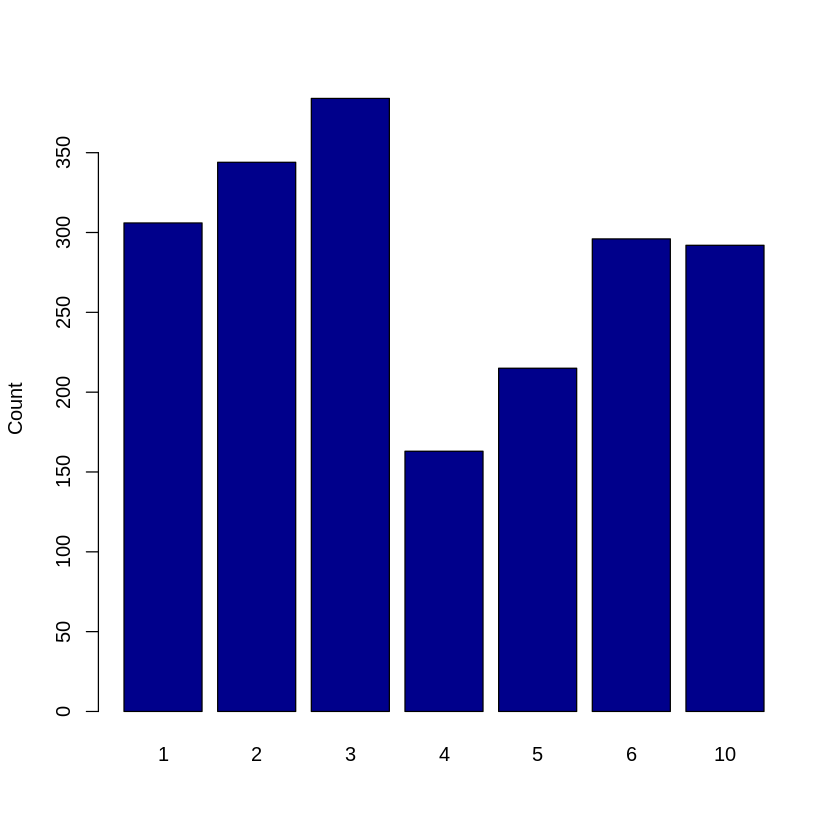

In [6]:
barplot(table(RDts1), ylab="Count", col="darkblue")

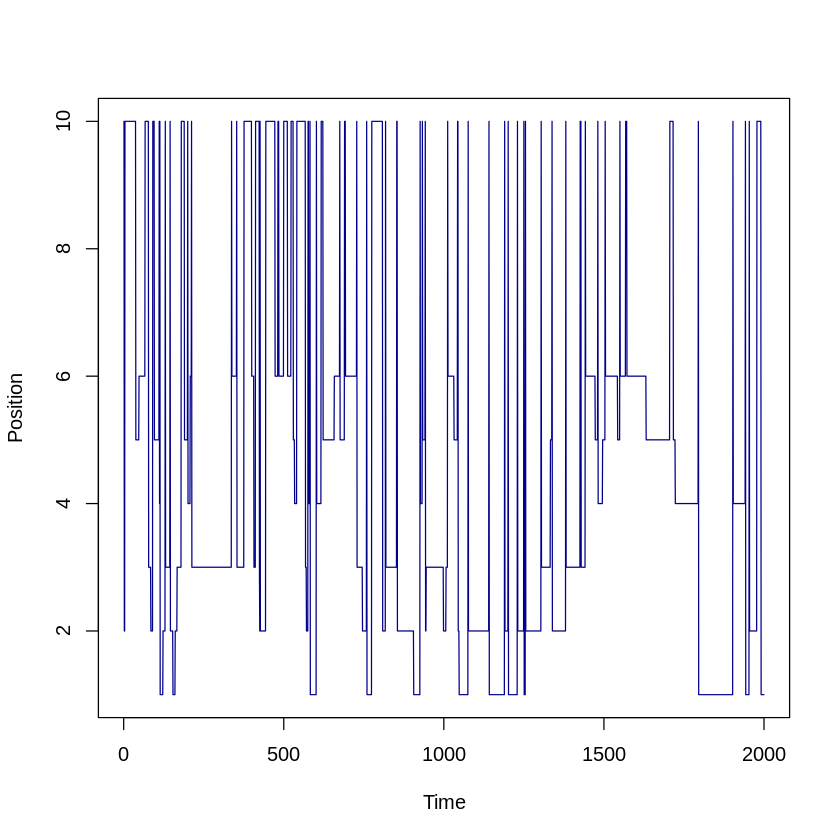

In [7]:
plot(as.ts(RDts1), col="darkblue", ylab="Position")

## Data Preparation

In [8]:
library(zoo)

# change matrix to timeseries
data <- as.zoo(RDts1)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [9]:
head(data)

  V1
1 10
2  2
3  2
4 10
5 10
6 10

In [10]:
# lagged

lag_transform <- function(data, seq_len){
    for(i in 1:seq_len) {
        lagged <- c(rep(NA, i), data[1:(length(data)-i)])
        if(i == 1){
            DF <- as.data.frame(cbind(lagged, data))
        } else {
            DF <- as.data.frame(cbind(lagged, DF))
        }
    }
    return(DF)
}

In [11]:
seq_len = 2
supervised = lag_transform(data, seq_len)
head(supervised, 25)

,lagged,lagged,V1
,<int>,<int>,<int>
1,NA,NA,10
2,NA,10,2
3,10,2,2
4,2,2,10
5,2,10,10
6,10,10,10
7,10,10,10
8,10,10,10
9,10,10,10


In [12]:
supervised <- supervised[-(1:seq_len), ]

head(supervised, 10)

,lagged,lagged,V1
,<int>,<int>,<int>
3,10,2,2
4,2,2,10
5,2,10,10
6,10,10,10
7,10,10,10
8,10,10,10
9,10,10,10
10,10,10,10
11,10,10,10


In [13]:
## split into train and test sets

total_data <- nrow(supervised)
jumlah_train_set <- round(total_data * 0.7, digits = 0)

train <- supervised[1:jumlah_train_set, ]
test  <- supervised[(jumlah_train_set+1):total_data,  ]

print(nrow(train))
print(nrow(test))

[1] 1399
[1] 599


In [14]:
## scale data

# scale_data <- function(train, test, feature_range = c(0, 1)) {
#   x <- train
#   fr_min <- feature_range[1]
#   fr_max <- feature_range[2]
#   std_train <- ((x - min(x) ) / (max(x) - min(x)  ))
#   std_test  <- ((test - min(x) ) / (max(x) - min(x)  ))
  
#   scaled_train <- std_train *(fr_max -fr_min) + fr_min
#   scaled_test <- std_test *(fr_max -fr_min) + fr_min
  
#   return( list(scaled_train = as.vector(scaled_train), scaled_test = as.vector(scaled_test) ,scaler= c(min =min(x), max = max(x))) )
  
# }


# Scaled = scale_data(train, test, c(-1, 1))

# y_train = Scaled$scaled_train[, 2]
# x_train = Scaled$scaled_train[, 1]

# y_test = Scaled$scaled_test[, 2]
# x_test = Scaled$scaled_test[, 1]

In [15]:
x_train = train[, 1]
y_train = train[, 2]

x_test = test[, 1]
y_test = test[, 2]

In [16]:
# Reshape the input to 3-dim
dim(x_train) <- c(length(x_train), 1, 1)

# specify required arguments
X_shape2 = dim(x_train)[2]
X_shape3 = dim(x_train)[3]
batch_size = 1                # must be a common factor of both the train and test samples
units = 1                     # can adjust this, in model tuninig phase

In [17]:
model <- keras_model_sequential() 

model%>%
    layer_lstm(units, batch_input_shape = c(batch_size, X_shape2, X_shape3), stateful= TRUE)%>%
    layer_dense(units = 1)

In [18]:
model %>% compile(
  loss = 'logcosh',
  optimizer = optimizer_sgd( lr= 0.01),  
  metrics = c('mean_squared_error')
)

In [19]:
summary(model)


Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
lstm (LSTM)                         (1, 1)                          12          
________________________________________________________________________________
dense (Dense)                       (1, 1)                          2           
Total params: 14
Trainable params: 14
Non-trainable params: 0
________________________________________________________________________________


In [20]:
nb_epoch = 100   

# for(i in 1:nb_epoch ){
#   model %>% fit(x_train, y_train, epochs=1, batch_size=batch_size, verbose=1, shuffle=FALSE)
#   model %>% reset_states()
# }

history <- model %>% fit(
 x = x_train,
 y = y_train,
 epochs = nb_epoch,
 batch_size = batch_size,
 validation_split = 0.2,
 verbose = 1
)

`geom_smooth()` using formula 'y ~ x'



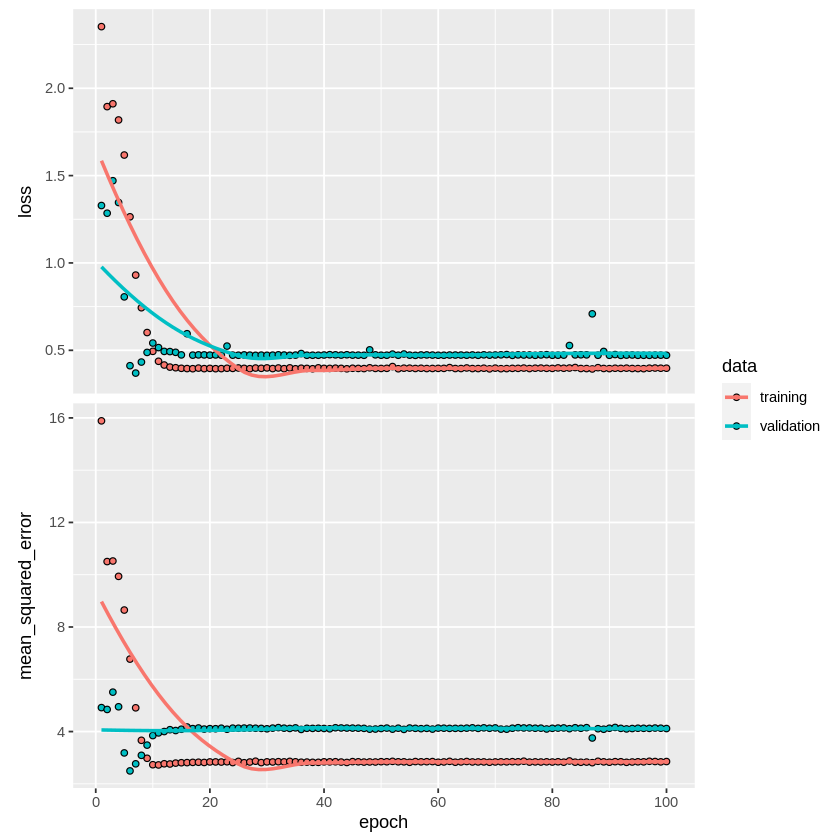

In [21]:
plot(history)

In [22]:
(score_train <- model %>% evaluate(x_train, y_train, batch_size=batch_size, verbose=0))

$loss
[1] 0.4029943

$mean_squared_error
[1] 3.082035

In [23]:
mse_train <- score_train$loss
rmse_train <- sqrt(score_train$loss)

cat("MSE: ", mse_train, "\n")
cat("RMSE:", rmse_train)

MSE:  0.4029943 
RMSE: 0.6348183

In [24]:
L = length(x_test)
predictions = numeric(L)

for(i in 1:L){
    X <- x_test[i]
    dim(X) <- c(1,1,1)
    X <- tf$cast(X, tf$float32)
    yhat <- model %>% predict(X, batch_size=batch_size)
    # store
    predictions[i] <- yhat
}

In [25]:
# Reshape the input to 3-dim
dim(x_test) <- c(length(x_test), 1, 1)

In [26]:
(score_test <- model %>% evaluate(x_test, y_test, batch_size=batch_size, verbose=0))

$loss
[1] 0.2256108

$mean_squared_error
[1] 1.674111

In [27]:
mse_test <- score_test$loss
rmse_test <- sqrt(score_test$loss)

cat("MSE: ", mse_test, "\n")
cat("RMSE:", rmse_test)

MSE:  0.2256108 
RMSE: 0.4749851